In [148]:
# Speech-to-Text V2 supported languages: https://cloud.google.com/speech-to-text/v2/docs/speech-to-text-supported-languages

In [136]:
from langchain_google_community import SpeechToTextLoader
from google.cloud.speech_v2 import RecognitionConfig, AutoDetectDecodingConfig
from google.cloud import storage

from pathlib import Path
from tqdm.auto import tqdm
import pandas as pd

In [122]:
bucket = storage.Client().bucket('trancriptions-mozilla')
project_id = "llm-study-409119"
files = [b.name for b in bucket.list_blobs() if b.name.endswith('.mp3')]

In [146]:
def generate_trancriptions():
    config = RecognitionConfig(model='telephony', auto_decoding_config=AutoDetectDecodingConfig(), language_codes=["pt-BR"])
    df = pd.DataFrame(columns=['file', 'transcription', 'total_seconds'])

    with tqdm(total=len(files), desc="Processing Files") as pbar:
        for f in files:
            file_path = f"gs://{bucket.name}/{f}"
            loader = SpeechToTextLoader(project_id=project_id, file_path=file_path, config=config)
            docs = loader.load()

            df.loc[len(df)] = Path(f).name, docs[0].page_content, docs[0].metadata['result_end_offset'].total_seconds()
            pbar.set_postfix(file_asdf=f)
            pbar.update(1)

    df.to_csv('data/gcp-stt.csv', index=False)
    print('Data saved to "data/gcp-stt.csv".')    

In [147]:
generate_trancriptions()

Processing Files: 100%|██████████| 100/100 [10:12<00:00,  6.13s/it, file_asdf=audios/09407.mp3]

Data saved to "data/gcp-stt.csv".


In [187]:
df = pd.read_csv('data/gcp-stt.csv')
df.nsmallest(10, 'total_seconds')

,file,transcription,total_seconds
67,04319.mp3,Juatuba,3.48
84,06344.mp3,o ponto é que dura no tempo,4.30
9,00161.mp3,todos os julgamentos dos órgãos do Poder Judic...,5.33
22,00708.mp3,mas se você fugir Faremos o mesmo,5.35
34,01582.mp3,para ser um comerciante você precisa de uma fa...,5.72
56,03622.mp3,uma mulher vestindo uma jaqueta preta está and...,5.81
41,01962.mp3,Canhotinho,5.93
54,03489.mp3,os orientaremos sobre maternidade e paternidade,5.94
26,01014.mp3,pleitear direito alheio em nome próprio salvo,6.21
3,00084.mp3,duas mulheres em uma menina levantam com troféus,6.32


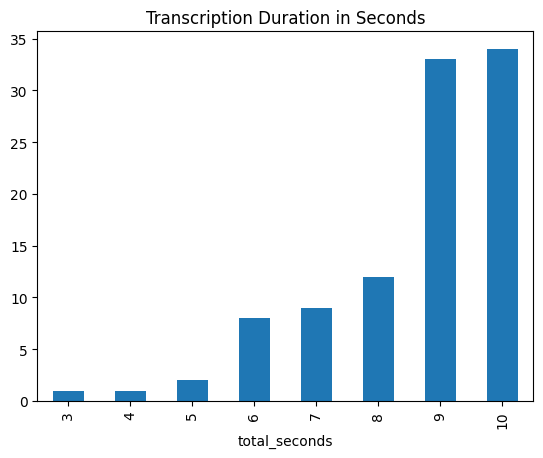

In [194]:
df.total_seconds.round(0).astype(int).value_counts().sort_index().plot.bar(title='Transcription Duration in Seconds');